# Predict C-to-U editing sites from nucleotide windows



## Environment

In [1]:
import numpy as np
import sklearn.metrics

import matplotlib.pyplot as plt

## Deepred-Mt installation

In [2]:
!pip install -U "deepredmt @ git+https://github.com/aedera/deepredmt.git" > /dev/null

  Running command git clone -q https://github.com/aedera/deepredmt.git /tmp/pip-install-zmq791rr/deepredmt


## Make predictions

To make predictions, we will use the nucleotide windows available in the data used to train Deepred-Mt.

In [3]:
!wget https://raw.githubusercontent.com/aedera/deepredmt/main/data/training-data.tsv.gz

--2021-04-22 18:55:27--  https://raw.githubusercontent.com/aedera/deepredmt/main/data/training-data.tsv.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3026591 (2.9M) [application/octet-stream]
Saving to: ‘training-data.tsv.gz.1’

training-data.tsv.g 100%[===================>]   2.89M  --.-KB/s    in 0.1s    

2021-04-22 18:55:28 (25.1 MB/s) - ‘training-data.tsv.gz.1’ saved [3026591/3026591]



As it is explained in the [README](https://github.com/aedera/deepredmt#datasets), these data is composed of ten fields.

In [4]:
!zcat training-data.tsv.gz | shuf | head -10 | column -t

Helianthus_annuus!rps03!160         rps03!160  1  ATCTGAATCGTAGTTCAGAT  T  CAAGTEGGTTCAGTGATTAT  TCA  1.0000  1  0.00
Ginkgo_biloba!ccmFc!123             ccmFc!123  3  ATGGTCCAACEACAGAACTT  C  TTCTTETTCATEAETTEEAT  TTC  0.0154  0  0.00
Physcomitrella_patens!nad7!1265     nad7!1268  2  TGGTACTCAAGATATTGTTT  T  TGGAGAGGTAGATAGATAGA  TTT  0.9995  1  0.00
Phoenix_dactylifera!atp1!1097       atp1!1109  2  TGCGTTACCCGTCATTGAAA  C  ACAAGCTGGAGACGTATCGG  ACA  0.0003  0  0.00
Ginkgo_biloba!nad7!1017             nad7!1017  3  CGATGTCAAATGAAACTATC  C  ATGGAATCCTEAATTCACCA  TCC  0.0064  0  0.00
Zea_mays!nad5!1125                  nad5!1134  3  GTCTTTCACTTAATGAATCA  C  GCGTTTTTCAAAGCATTACT  CAC  0.0040  0  0.00
Liriodendron_tulipifera!rpl10!376   rpl10!397  4  CATEGGACAGGTEGGAGTTC  C  TACCTTCTTGGGACTCCATG  CTA  0.0037  0  0.00
Phoenix_dactylifera!nad5!1736       nad5!1745  2  AGCGGATCAATTCCAACGAG  C  CTTTCAAACTAGTACTTTTT  GCC  0.0002  0  0.00
Liriodendron_tulipifera!nad6-1!287  nad6!290   2  AGTTEA

From these data, we will only use the nucleotide windows with either cytidines (C) or editing sites (E) in their center positions (field #5).

In [5]:
!zcat training-data.tsv.gz | \
  awk -F$'\t' '($$5 == "C" || $$5 == "E")' > reduced-data.tsv
  
!shuf reduced-data.tsv | head -10 | column -t

Malus_domestica!ccmFn!469      ccmFn!490   1  AAAGCCATAATGTCTCAAAA  C  GAGGAGGCCATAGAGAAACT  CGA  0.0000  0  0.00
Silene_conica!atp1!1172        atp1!1184   2  TGGACAAATCTGTTTGGAAA  C  AGAGCTTTTTTATAGAGGAA  ACA  0.0000  0  0.00
Rhazya_stricta!rps03!1493      rps03!1931  2  TCAAGACATCTCTTTTCAAC  E  GAGGAACAAAACAAGATCAT  CEG  0.9191  1  0.86
Allium_cepa!atp9!361           atp9!394    1  AGATGCTTAAAAGCGCTTTG  C  CTTACCTATGATGAAATTCC  CCT  0.0001  0  0.00
Silene_conica!ccmFn!1024       ccmFn!1129  1  GGATTGTGGCACTCTACTCG  C  CGGCAATGCGTAAGGATGCC  CCG  0.0000  0  0.00
Allium_cepa!nad4!719           nad4!719    2  TTTACAAATATTATTAACCA  C  AGAATTTAGTGAGCGGCGCC  ACA  0.0011  0  0.00
Nelumbo_nucifera!atp6!380      atp6!806    2  AAATGTTAAACAAAAGTTTT  E  CCCTTGCATCTEGGTCACTT  TEC  0.9648  1  1.00
Arabidopsis_thaliana!matR!768  matR!861    3  GCCGTCTTCCTTAACAAGCC  C  TCGAGCCTTCTTTGCGCCGC  CCC  0.0006  0  0.00
Zea_mays!cob!302               cob!302     2  CACACCTCATGTGGATCTAG  C  TTTCAACAGCGTAGAAC

From the reduced data, we will extract the nucleotide windows (fields #4, #5, and #6). 

In [6]:
!cat reduced-data.tsv | \
  cut -f4,5,6 | \
  tr -d '\t' > wins.tsv

!shuf wins.tsv | head -10 | column -t

TTACCAATTCTTATGCTAATCCTAAGAAATTCCGTTCAAGA
GTATGTTTTTCATTGTGGTTEACCTTCATATTTTTCGTGGT
TTAACTAAGTATCAAATTGACCGAATTATCAAAATAATAAG
TTCGTTCCEGCTTTTCATTTCETTCTTCTCGAATCCAAAGG
TTCGTGCEGAACCEGGTAAACGAACAAATAGGTGGTCTTTC
CACAAAGAAGATACAGTTCACTCAACGATTGCCTTTGGGTT
AGGTTTAGTGAGCACCATGCCGAATETCTCTACCATTTTCT
GTTTTCCCATGTTACAACTTEEGTACCAATTCGATCGATCC
TGATGCGCCCATTCCTATGGCCATTCCTTTAATACTTCTGG
TCATATCGTATCGACTTTTTCGGGAAAACCGGTCTTCGGGT


Now, we can execute Deepred-Mt using the file `training-dataset.tsv` as input.

In [7]:
!deepredmt wins.tsv > deepredmt-pred.tsv

The output file `deepredmt-pred.tsv` contains the Deepred-Mt predictions. To facilitate downstream analyses, we can add these predictions as a new last column in the original data.

In [8]:
!paste reduced-data.tsv deepredmt-pred.tsv > all-wins.tsv
!head -10 all-wins.tsv | column -t

Allium_cepa!atp1!1002  atp1!1020  3  GCTTTCCCTGGGGATGTTTT  C  TATTTACATTCCCGTCTCTT  TTC  0.0011  0  0.00  0.03
Allium_cepa!atp1!1009  atp1!1027  1  CTGGGGATGTTTTCTATTTA  C  ATTCCCGTCTCTTAGAAAGA  CAT  0.0002  0  0.00  0.01
Allium_cepa!atp1!1013  atp1!1031  2  GGATGTTTTCTATTTACATT  C  CCGTCTCTTAGAAAGAGCCG  TCC  0.0002  0  0.00  0.01
Allium_cepa!atp1!1014  atp1!1032  3  GATGTTTTCTATTTACATTC  C  CGTCTCTTAGAAAGAGCCGC  TCC  0.0010  0  0.00  0.02
Allium_cepa!atp1!1015  atp1!1033  1  ATGTTTTCTATTTACATTCC  C  GTCTCTTAGAAAGAGCCGCT  CGT  0.0000  0  0.00  0.00
Allium_cepa!atp1!1018  atp1!1036  1  TTTTCTATTTACATTCCCGT  C  TCTTAGAAAGAGCCGCTAAA  CTC  0.0002  0  0.00  0.00
Allium_cepa!atp1!1020  atp1!1038  3  TTCTATTTACATTCCCGTCT  C  TTAGAAAGAGCCGCTAAACG  CTC  0.0018  0  0.00  0.01
Allium_cepa!atp1!1031  atp1!1049  2  TTCCCGTCTCTTAGAAAGAG  C  CGCTAAACGATCGGACCAGA  GCC  0.0000  0  0.00  0.00
Allium_cepa!atp1!1032  atp1!1050  3  TCCCGTCTCTTAGAAAGAGC  C  GCTAAACGATCGGACCAGAC  GCC  0.0000  0  0.00  0.02
A

## Comparing the predictive performance of PREP-Mt and Deepred-Mt

Based on these predictions. We can compare the predicive performance of Deepred-Mt with that of [PREP-Mt](http://prep.unl.edu/), a state-of-the-art method to predict editing sites. PREP-Mt predictions are already available in the field #10 in the data used above.



To measure the predictive performance, precision and recall are standard metrics often used when the classes are imbalanced. You can find more information regarding these metrics in other [notebook](https://colab.research.google.com/github/aedera/deepredmt/blob/main/notebooks/01_prediction_from_fasta.ipynb).

In [9]:
def performance(y_true, y_pred):                                                                                                                                                   
    """Calculate recall, precision, and F1."""
    pr = sklearn.metrics.precision_score(y_true, y_pred)
    re = sklearn.metrics.recall_score(y_true, y_pred)
    F1 = sklearn.metrics.f1_score(y_true, y_pred)

    return pr, re, F1 

In [10]:
# This command reads the columns 9, 10, 11 in the all-wins.tsv
preds = np.loadtxt('all-wins.tsv', usecols=(8, 9, 10))
y_true, y_prepmt, y_deepredmt = preds[:,0], preds[:,1], preds[:,2]

print(y_true[0:10], y_prepmt[0:10], y_deepredmt[0:10])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.03 0.01 0.01 0.02 0.   0.   0.01 0.   0.02 0.  ]


In [11]:
# calculate metrics for different thresholds
prepmt_scores = [performance(y_true, y_prepmt >= t) for t in np.arange(0, 1.01, .01)]
prepmt_scores = np.asarray(prepmt_scores)

deepredmt_scores = [performance(y_true, y_deepredmt >= t) for t in np.arange(0, 1.01, .01)]
deepredmt_scores = np.asarray(deepredmt_scores)

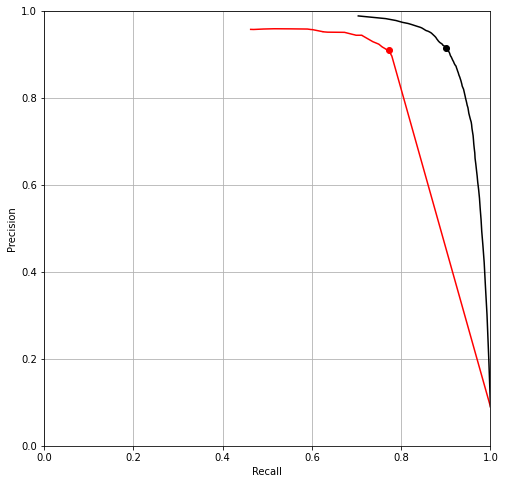

In [12]:
# Plot results
fig, ax = plt.subplots(figsize=(8, 8))

# draw curves
plt.plot(prepmt_scores[:,1], prepmt_scores[:,0], c='red')
plt.plot(deepredmt_scores[:,1], deepredmt_scores[:,0], c='black')

# show f1max
nrow = np.argmax(prepmt_scores[:,2])
plt.plot(prepmt_scores[nrow,1], prepmt_scores[nrow,0], 'ro', c='red')

nrow = np.argmax(deepredmt_scores[:,2])
plt.plot(deepredmt_scores[nrow,1], deepredmt_scores[nrow,0], 'ro', c='black')

plt.xlabel('Recall')
plt.ylabel('Precision')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
plt.grid(True)

plt.show()